# **Chapter 5: Fundamentals of machine learning**

---

- Understanding tension between generalization and optimization: fundamental issue in ML
- Evalauation methods for ML models.
- Best practices to improve model fitting.
- Best practices to achieve better generalization.


# 5.1 Generalization: The goal of machine learning

- From last chapters' examples, we see we can't evaluate models on the same data they were trained on: after just a few epochs, performance on new data diverges from performance on training data (which always improves).
- Fundamental issue in ML: tension between optimization and generalization.
  - ***Optimization***: process of tuning the model to get the best performance on the training data (learning).
  - ***Generalization***: how well the trained model performs on new data.

If you fit the mode to training data *too well*, overfitting kicks in. But what causes overfitting? How to achieve god generalization?

## 5.1.1 Underfitting and overfitting

- Previously, we saw performance on validation data improved at first and then inevtiably peaked after some time——this pattern is universal:
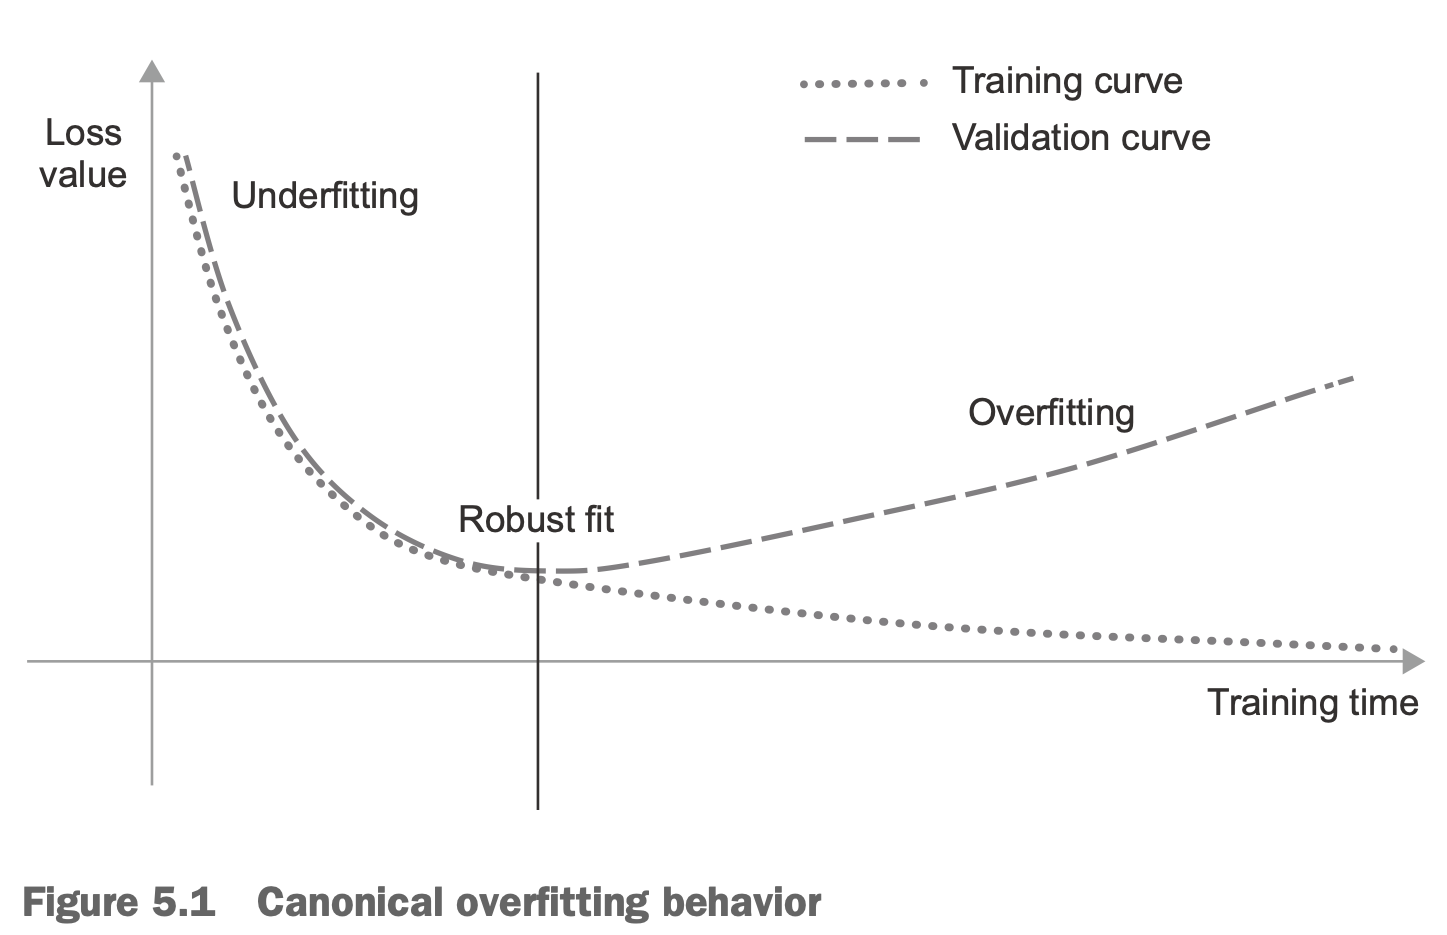

- At beginning, generalization and optimization are correlated: lower the loss on training data \Rightarrow lower the loss on test data.
  - During this, our model is said to be ***underfit***.
  - Afterwards, when generalization stops increasing, our model starts to overfit.
  - Means, it stars to learn patterns specific to training data but misleading/irrelevant to new data.
  - This is likely to occur when our data is *noisy* (invloves uncertainty or rare features).

### Noisy Training Data:
- We might get invalid inputs, like:
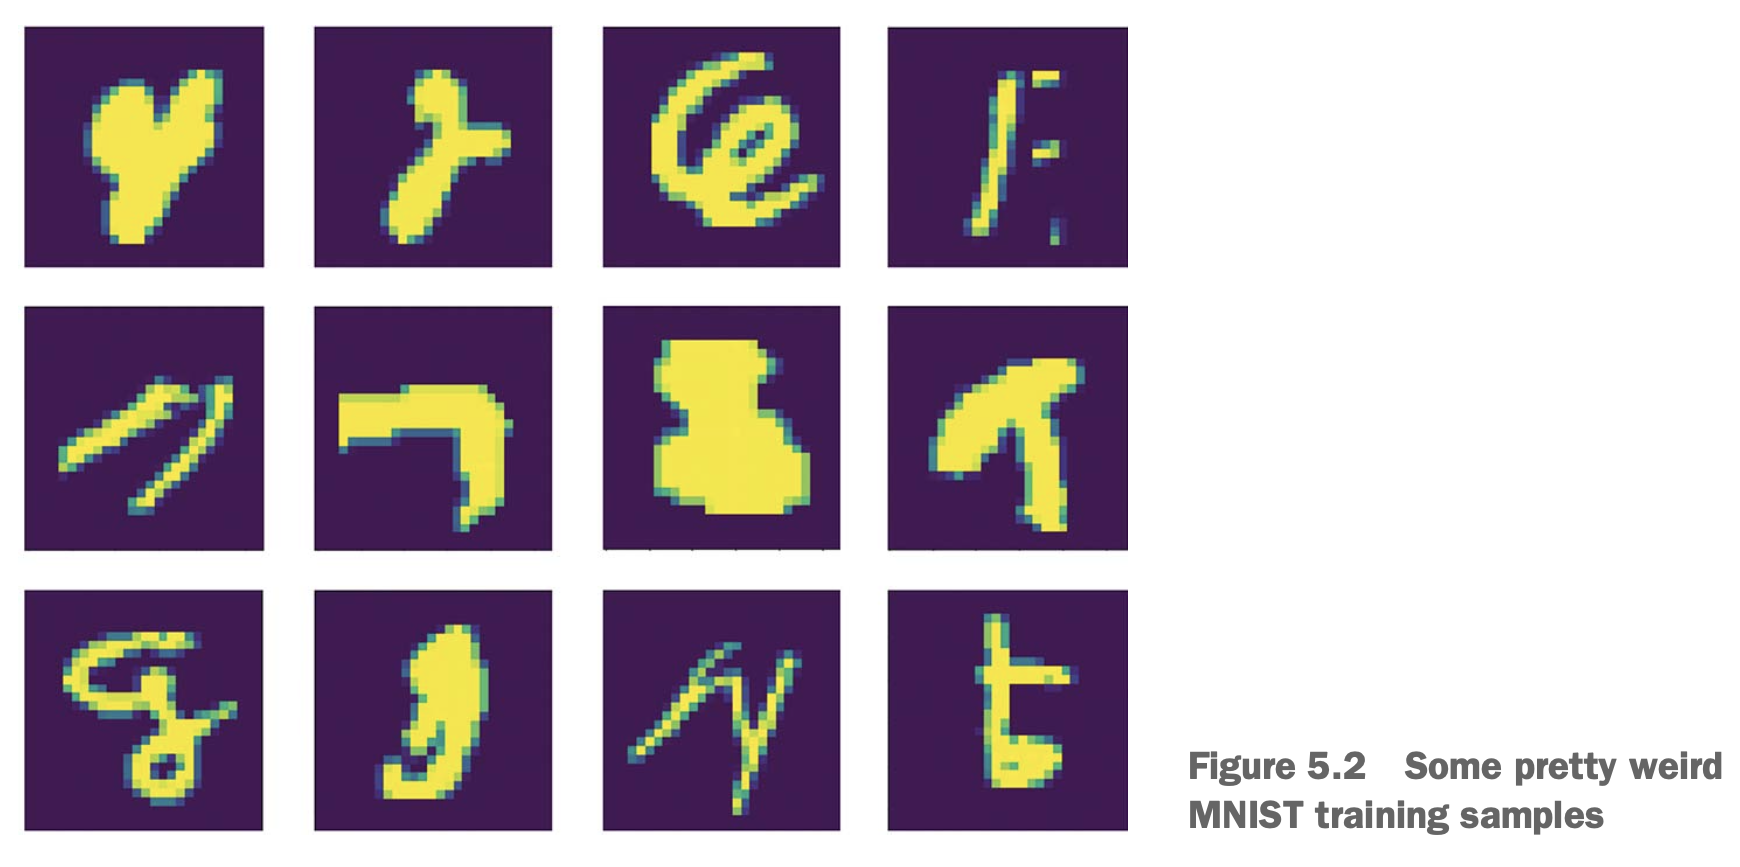

They're all part of the MNIST training data.
- Even worse: perfectly valid inputs being misalabeled.
- This happens when a model goes out of its way to incorporate such outliers. This causes the generalization to degrade:

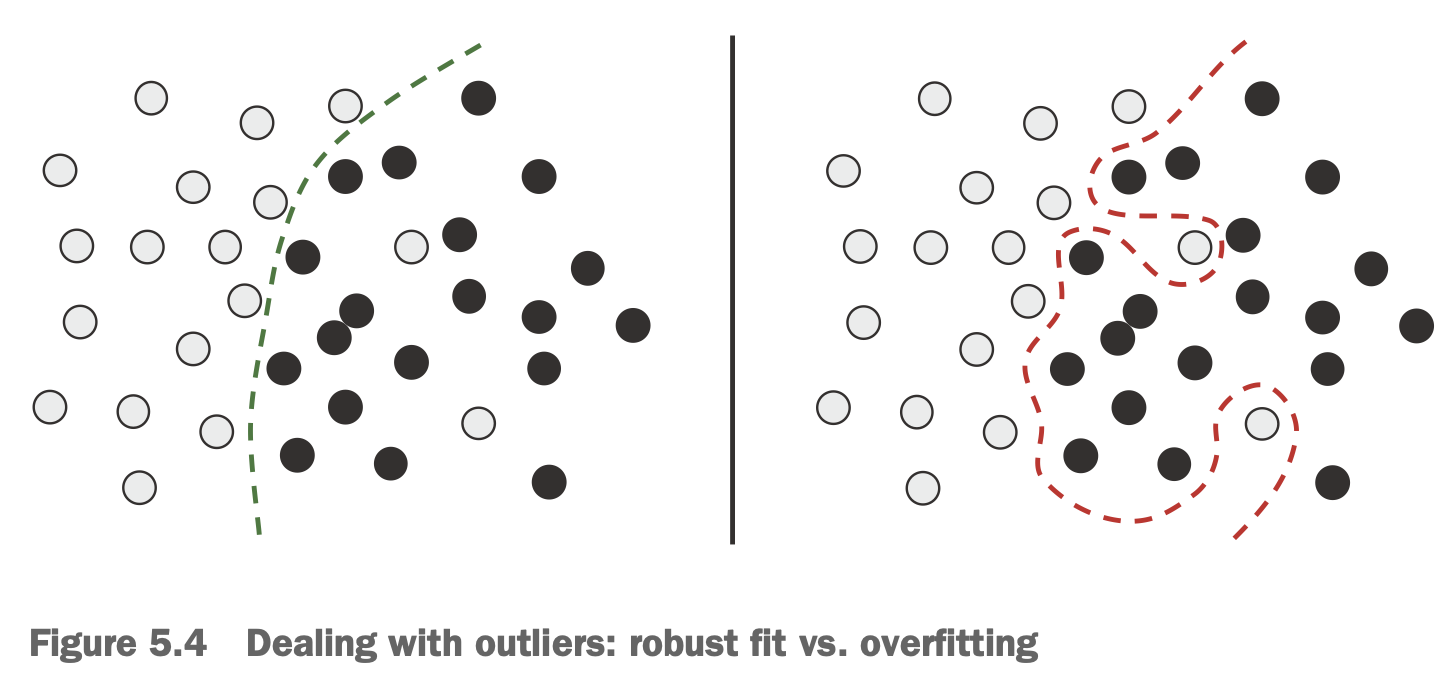

### Ambiguous Features

- Not all data noise comes from inaccuracies: might come from uncertainty and ambiguity.
- Many problems involve randomness: rain prediction from atmospheric data is probabilistic.
- Model could overfit to such probab. data by being too confident about ambiguous regions.
- A more robust fit would ignore data points and look at the bigger picture

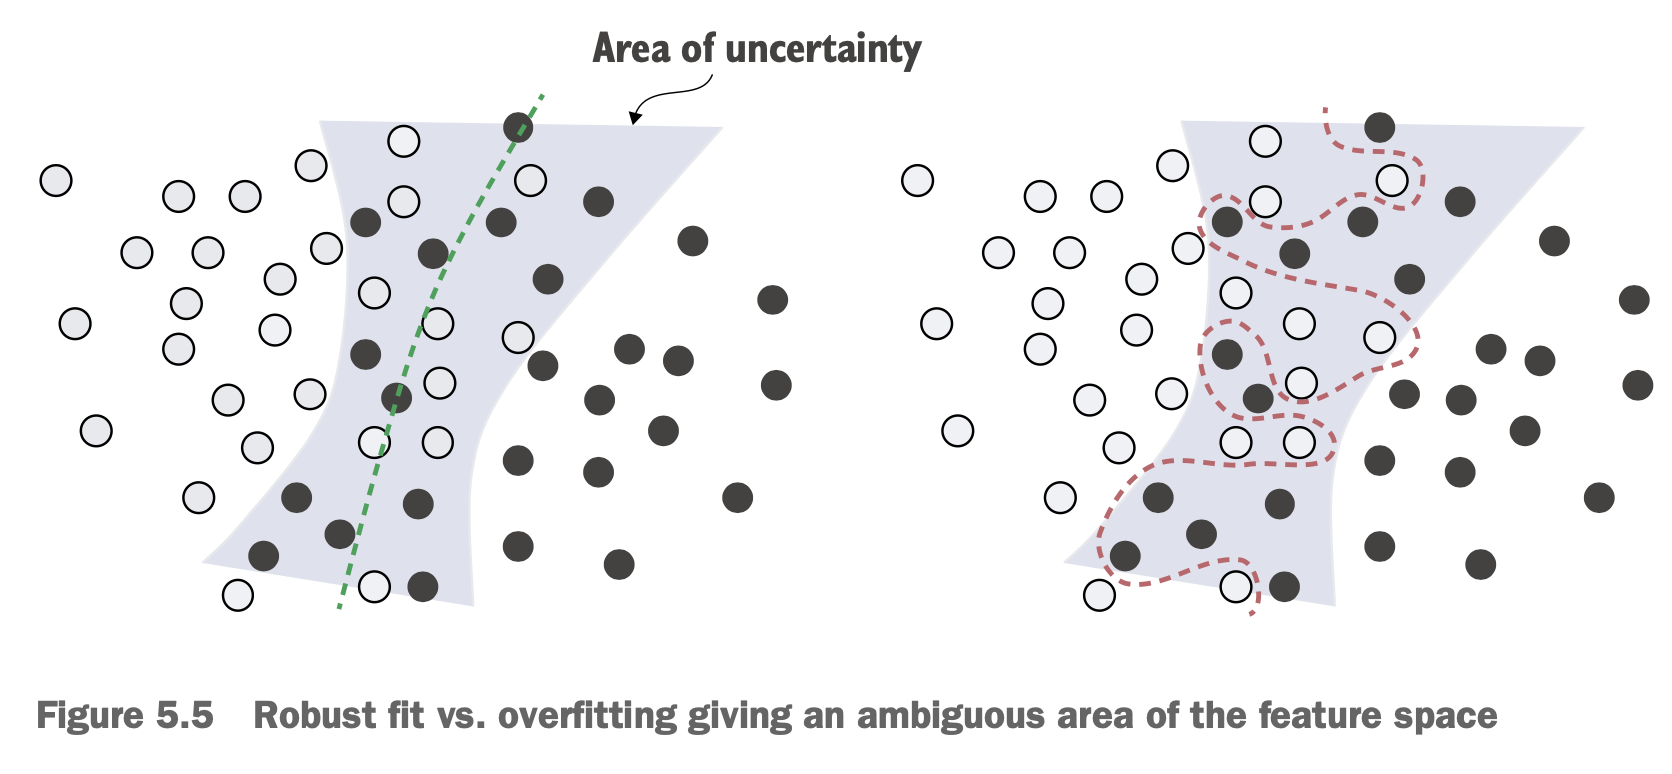

### Rare features and spurious correlations

- If you see only two orange tabby cats and both are not friendly, you might infer orange tabby cats are not friendly. But if you have more data, you will see that color is not correlated to character.
- Datasets that have rare feature values are highly susceptible to overfitting.
- A poorly regularized model might put too much weight on a feature.

MNIST example:
- Create 2 new training sets: one with 784 white noise dimensions and concatenate with original data, and other with with 784 all-zeros dimensions.

### Adding white noise and all-zeros channels to MNIST

In [2]:
from tensorflow.keras.datasets import mnist
import numpy as np

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

train_images_with_noise_channels = np.concatenate(
    [train_images, np.random.random((len(train_images), 784))], axis=1
)
train_images_with_zeros_channels = np.concatenate(
    [train_images, np.zeros((len(train_images), 784))], axis=1
)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Training the same model on MNIST data with noise and all-zeros channels

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model():
  model = keras.Sequential([
      layers.Dense(512, activation="relu"),
      layers.Dense(10, activation="softmax")
  ])
  model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
  return model

model = get_model()
history_noise = model.fit(
    train_images_with_noise_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

model = get_model()
history_zeros = model.fit(
    train_images_with_zeros_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.6962 - loss: 1.1222 - val_accuracy: 0.9097 - val_loss: 0.3292
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9105 - loss: 0.2859 - val_accuracy: 0.9382 - val_loss: 0.2108
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9475 - loss: 0.1738 - val_accuracy: 0.9477 - val_loss: 0.1701
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9608 - loss: 0.1262 - val_accuracy: 0.9578 - val_loss: 0.1453
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9724 - loss: 0.0911 - val_accuracy: 0.9598 - val_loss: 0.1373
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9791 - loss: 0.0682 - val_accuracy: 0.9668 - val_loss: 0.1149
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9854 - loss: 0.0481 - val_accuracy: 0.9632 - val_loss: 0.1401
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9887 - loss: 0.0350 - val_ac

### Plotting a validation accuracy comparison

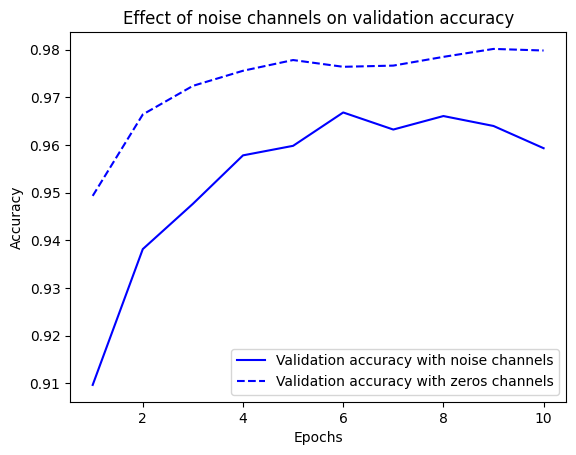

In [4]:
import matplotlib.pyplot as plt
val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]
epochs = range(1, 11)
plt.plot(epochs, val_acc_noise, "b-",
         label="Validation accuracy with noise channels")
plt.plot(epochs, val_acc_zeros, "b--",
         label="Validation accuracy with zeros channels")
plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

- Validation accuracy on white noise is 1% lower than on all-zero channels.
  - Through the influence of spurious relations.
- Noisy features inevitably lead to overfitting.
- When unsure about a features, do ***feature selection***. We did this in IMDB by selecting the top 10,000 most frequent words.
- Typical way to do this: calculate the impact of features on labels, and only keep features whose usefulness score is above some threshold value.

## 5.1.2 The nature of generalization in deep learning

- DL models can be trained to fit anything, as long as they have enough representational power.
- Example: let's try shuffling the MNIST labels and train a model.

### Fitting an MNIST model with randomly shuffled labels

In [6]:
(train_images, train_labels), _ = mnist.load_data()
print(train_images.shape)
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
print(train_images.shape)

(60000, 28, 28)
(60000, 784)


In [11]:
random_train_labels = train_labels
np.random.shuffle(random_train_labels)

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, random_train_labels,
          epochs=100,
          batch_size=128,
          validation_split=0.2)

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.1056 - loss: 2.3295 - val_accuracy: 0.1074 - val_loss: 2.3037
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.1164 - loss: 2.2977 - val_accuracy: 0.1013 - val_loss: 2.3078
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.1304 - loss: 2.2889 - val_accuracy: 0.0968 - val_loss: 2.3186
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.1401 - loss: 2.2758 - val_accuracy: 0.1016 - val_loss: 2.3269
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1526 - loss: 2.2610 - val_accuracy: 0.0970 - val_loss: 2.3379
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.1683 - loss: 2.2404 - val_accuracy: 0.1076 - val_loss: 2.3454
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.1890 - loss: 2.2148 - val_accuracy: 0.1037 - val_loss: 2.3582
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2034 - loss: 2.1875

-  We can do this even on white noise inputs and random labels (with enough params)
  - Would end up memorizing specific inputs.
- ***How come DL models generalize at all then?***
  - More to do with the structure of info. in the real world, rather than the DL model itself.
  

### **The Manifold hypothesis**

- Machine learning models only have to fit relatively simple, low-dimensional, highly structured subspaces within their potential input space (latent mani- folds).
- Within one of these manifolds, it’s always possible to interpolate between two inputs, that is to say, morph one into another via a continuous path along which all points fall on the manifold.


The ability to interpolate between samples is the key to understanding generalization in DL.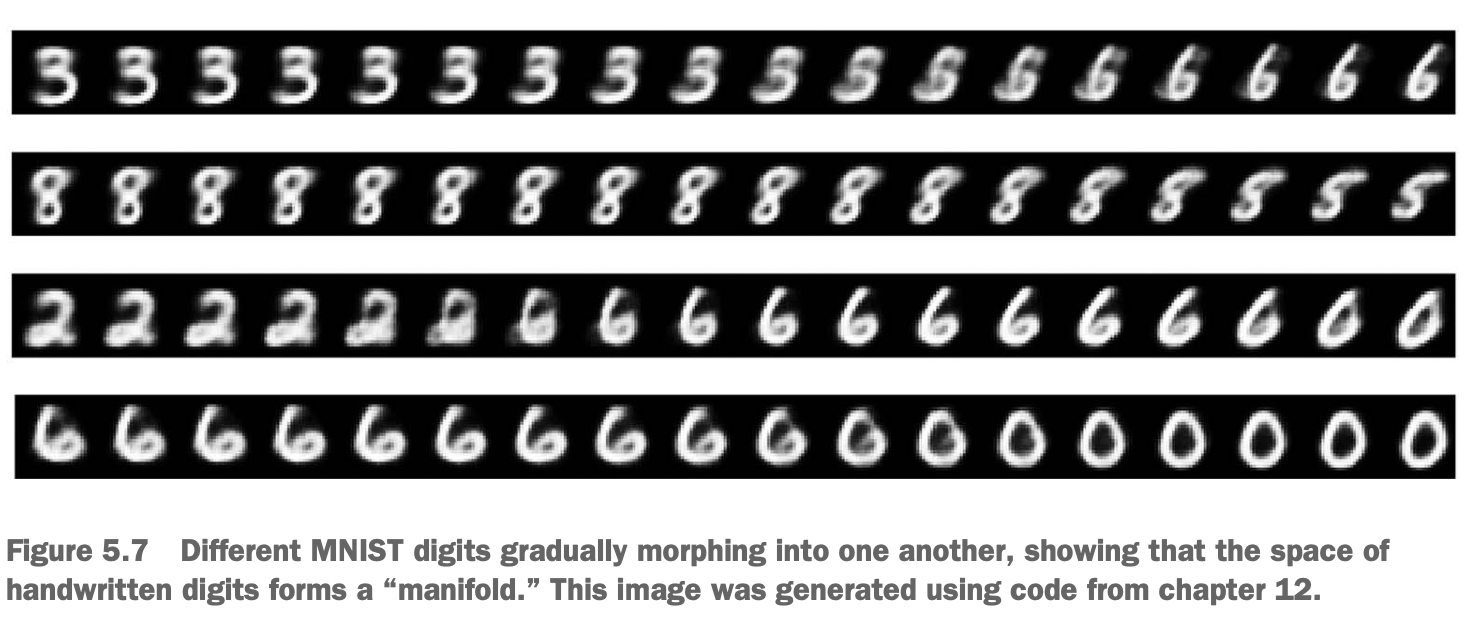


### **Interpolation as a source of generalization**

- If data points can be interpolated, your model would work well on unseen data.
  - It can make sense of the *totality* of space using only a *sample* of the space.

- But, iterpolation is *not all* there is to generalization.
- Interpolation can only help you make sense of things that are very close to what you’ve seen before: enables ***local generalization***.
- Humans are capable of *extreme generalization*.
- We do this by cognitive mechanisms (abstraction, reasoning, etc.). These are called ***reason*** (not interpolative in nature) as opposed to intuition or pattern recognition (largely interpolative).

### **Why deep learning works**

- DL model is a tool for uncrumpling paper balls——for disentangling latent manifolds.
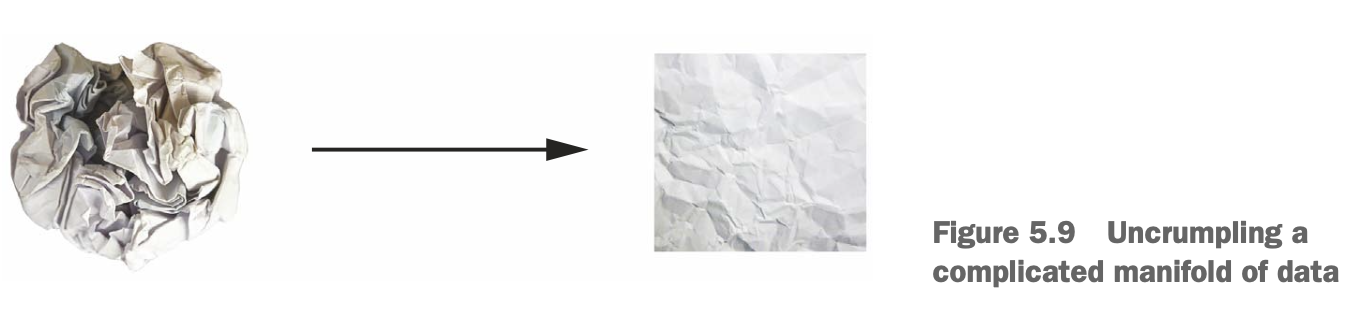

- DL model is a high dimensional smooth and conitunous curve.
- This curve is fitted to data via GD.
- SO DL is about taking a big complex curve——a manifold——and incrementally adjusting its params until it fits the training data.
- Our data forms a highly structured low-dimensional manifold within the input space——this is the manifold hypothesis.


Properties of deep learning models that make them particularly well-suited to learning latent manifolds:
- Deep learning models implement a smooth, continuous mapping from their
inputs to their outputs. It has to be smooth and continuous because it mustbe differentiable, by necessity (you couldn’t do gradient descent  otherwise). This smoothness helps approximate latent manifolds, which follow the same properties.
- Deep learning models tend to be structured in a way that mirrors the “shape” of the information in their training data (via architecture priors).More generally, deep NNs structure their learned representations in a hierarchical and modular way, which echoes the way natural data is organized.

### **Training data is paramount**

- Generalization depends more on the structure of your data than on any property of your model.
- Only be able to generalize if data forms a manifold where points can be interpolated.
- Data curation and engineering are essential to generalization.
- *Model needs to be trained on a dense sampling of its input space*:


- 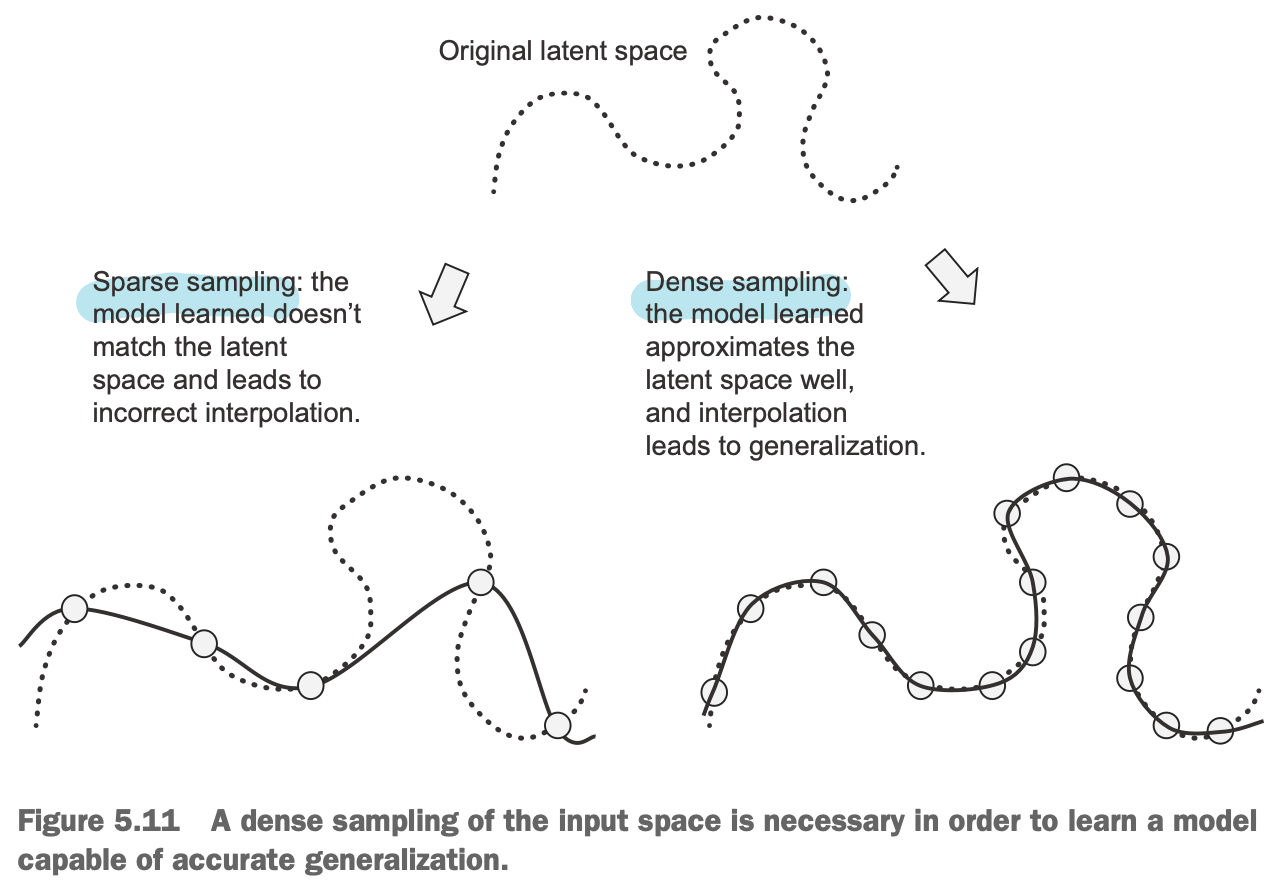

- Best way to improve a DL model is to train it on more or better data.
- If a network can only afford to memorize a small number of patterns, or very regular patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well. The process of fighting overfitting this way is called ***regularization***.

Before tweaking the model to make it generalize better, we need to asses how it's currently doing. Next step is thus: model evaluation.